In [21]:
import pickle
import os
import gc
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans, Birch
from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.metrics import homogeneity_score
from scipy.stats import entropy
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse
from sklearn.cluster import DBSCAN
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.cluster import KMeans
from collections import defaultdict
from matplotlib.animation import FuncAnimation
from scipy.stats import kruskal
from scipy.stats import f_oneway, kruskal
from fairis_tools.experiment_tools.place_cell.PlaceCellLibrary import *
from tqdm import tqdm

In [3]:
os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [22]:
with open("data/VisualPlaceCellData/LMO8_Testing_wall", 'rb') as file:
    test_data = pickle.load(file)
modes = ['nearest_same_orientation','nearest_different_orientation', 'farthest_same_orientation', 'farthest_different_orientation']
thetas = [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793, 3.9269908169872414, 4.71238898038469, 5.497787143782138]
landmarks = [
    (1.85, 1.85, (1.00, 0.00, 0.00)),
    (0.00, 2.61, (0.00, 1.00, 0.00)),
    (-1.85, 1.85, (0.00, 0.00, 1.00)),
    (-2.61, 0.00, (1.00, 1.00, 0.00)),
    (-2.61, 0.00, (1.00, 0.00, 1.00)),
    (-1.85, -1.85, (0.00, 1.00, 1.00)),
    (0.00, -2.61, (1.00, 0.50, 0.00)),
    (1.85, -1.85, (0.50, 0.00, 0.50)),
    (2.61, 0.00, (0.50, 0.50, 0.00))
]

walls = [
    ((0.75, -1.25), (-0.75, -1.25)),  # Wall 1
    ((0.75, 1.25), (-0.75, 1.25)),    # Wall 2
    ((1.25, 0.75), (1.25, -0.75)),    # Wall 3
    ((-1.25, 0.75), (-1.25, -0.75)),  # Wall 4
    ((0.50, -0.50), (-0.50, 0.50)),   # Wall 5
    ((-0.50, -0.50), (0.50, 0.50))    # Wall 6
]



In [23]:
def group_dataset_by_theta(dataset):
    """
    Groups observations in the dataset by unique theta values. This function
    does not consider spatial proximity (x, y coordinates) during grouping.

    Parameters:
    - dataset: An object with an 'observations' attribute, which is a list of observations.
               Each observation is expected to have a 'theta' attribute.

    Returns:
    - dict: A dictionary where the keys are unique theta values, and the values are
            lists of observations corresponding to each theta.
    """
    # Initialize a dictionary to store the grouped observations by theta
    theta_groups = defaultdict(list)

    # Iterate through the observations and group them by their theta value
    for observation in dataset.observations:
        theta_groups[observation.theta].append(observation)

    return theta_groups

def select_knn_with_orientation(grouped_data, orientation, k, mode='nearest_same_orientation', point=None):
    """
    Selects k data points based on spatial proximity and orientation.

    Parameters:
    - grouped_data: dict, output of group_dataset_by_theta function {theta: [data_points]}.
    - orientation: float, the orientation (theta) to select the initial data point from.
    - k: int, the number of neighbors to select.
    - mode: str, selection mode ('nearest_same_orientation', 'farthest_same_orientation',
             'farthest_different_orientation', 'nearest_different_orientation').
    - point: tuple (x, y) or None; if None, a random point is selected.

    Returns:
    - list: A list containing k selected data points based on the chosen mode.
    """
    if mode not in ['nearest_same_orientation', 'farthest_same_orientation',
                    'farthest_different_orientation', 'nearest_different_orientation']:
        raise ValueError("Invalid mode. Choose from 'nearest_same_orientation', 'farthest_same_orientation', "
                         "'farthest_different_orientation', or 'nearest_different_orientation'.")

    if mode == 'nearest_same_orientation':
        # Get all points with the same orientation
        if orientation not in grouped_data or len(grouped_data[orientation]) == 0:
            raise ValueError(f"No data points available for the specified orientation: {orientation}")

        data_points = grouped_data[orientation]

        # Select the initial data point
        if point is None:
            selected_point = random.choice(data_points)
        else:
            # Find the closest point to the provided coordinates
            distances = cdist([point], [(dp.x, dp.y) for dp in data_points])[0]
            selected_index = np.argmin(distances)
            selected_point = data_points[selected_index]

        selected_point_coords = np.array([selected_point.x, selected_point.y])

        # Find the k nearest neighbors
        distances = cdist([selected_point_coords], [(dp.x, dp.y) for dp in data_points])[0]
        nearest_indices = np.argsort(distances)[:k + 1]  # +1 to include the selected point

        # Return the initial point and k nearest neighbors
        return [data_points[i] for i in nearest_indices if data_points[i] != selected_point][:k]

    if mode == 'nearest_different_orientation':
        # Get all points with different orientations
        candidate_points = [dp for theta, points in grouped_data.items() if theta != orientation for dp in points]
        if len(candidate_points) == 0:
            raise ValueError("No data points available with different orientations.")

        # Select the initial data point
        if point is None:
            selected_point = random.choice(candidate_points)
        else:
            # Find the closest point to the provided coordinates
            distances = cdist([point], [(dp.x, dp.y) for dp in candidate_points])[0]
            selected_index = np.argmin(distances)
            selected_point = candidate_points[selected_index]

        selected_point_coords = np.array([selected_point.x, selected_point.y])

        # Compute distances to all candidates
        distances = cdist([selected_point_coords], [(dp.x, dp.y) for dp in candidate_points])[0]
        nearest_indices = np.argsort(distances)[:k]  # Select k nearest neighbors

        return [candidate_points[i] for i in nearest_indices]

    if mode in ['farthest_same_orientation', 'farthest_different_orientation']:
        if mode == 'farthest_same_orientation':
            if orientation not in grouped_data or len(grouped_data[orientation]) == 0:
                raise ValueError(f"No data points available for the specified orientation: {orientation}")
            candidate_points = grouped_data[orientation]
        else:
            # Different orientation points
            candidate_points = [dp for theta, points in grouped_data.items() if theta != orientation for dp in points]
            if len(candidate_points) == 0:
                raise ValueError("No data points available with different orientations.")

        # Step 3: Convert points to (x, y) coordinates
        candidate_coords = np.array([(dp.x, dp.y) for dp in candidate_points])

        # Select the initial point
        if point is None:
            # Randomly select the first point
            selected_indices = [random.randint(0, len(candidate_coords) - 1)]
            selected_points = [candidate_points[selected_indices[0]]]
        else:
            # Find the closest point to the provided coordinates
            distances = cdist([point], candidate_coords)[0]
            selected_index = np.argmin(distances)
            selected_indices = [selected_index]
            selected_points = [candidate_points[selected_index]]

        # Step 4: Greedy selection of k points that maximize pairwise distances
        while len(selected_indices) < k:
            # Calculate distances from the current set of selected points to all candidates
            distances_to_selected = np.min(cdist(candidate_coords, candidate_coords[selected_indices]), axis=1)

            # Exclude already selected points
            distances_to_selected[selected_indices] = -np.inf

            # Select the point with the maximum distance to the current selection
            next_index = np.argmax(distances_to_selected)
            selected_indices.append(next_index)
            selected_points.append(candidate_points[next_index])

        return selected_points

def calculate_and_visualize_similarity(data_points, pc_network, feature_type='multimodal', landmarks=None, walls=None):
    """
    Calculate and visualize similarity metrics for a list of grouped data points.
    Includes spatial plots with landmarks, similarity heatmaps, and bar graphs of place cell activations.

    Parameters:
    - data_points: list of data points where each point contains attributes 'x', 'y', 'theta',
                   and feature vectors ('cnn_feature_vector', 'multimodal_feature_vector').
    - pc_network: object, the place cell network used to get activations.
    - feature_type: str, the feature type used to calculate activations ('cnn' or 'multimodal').
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.

    Returns:
    - None, but displays the combined visualization.
    """
    # Determine the layout of subplots (square layout)
    num_points = len(data_points)
    num_cols = math.ceil(math.sqrt(num_points + 4))  # +4 to account for 3 heatmaps + spatial plot
    num_rows = num_cols  # Ensure a square layout

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()

    # First plot: spatial layout (x, y) with orientation vector
    spatial_ax = axes[0]
    x_coords = [dp.x for dp in data_points]
    y_coords = [dp.y for dp in data_points]
    thetas = [dp.theta for dp in data_points]

    # Build the octagon using landmark positions if provided
    if landmarks is not None:
        landmark_positions = [(x, y) for (x, y, _) in landmarks]

        # Sort landmarks based on their angle from the origin to create an ordered octagon
        landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))
        octagon_vertices = np.array(landmark_positions + [landmark_positions[0]])  # Close the octagon

        # Plot the octagon
        spatial_ax.plot(octagon_vertices[:, 0], octagon_vertices[:, 1], color='black', linewidth=2)

        # Plot landmarks
        for (x, y, (r, g, b)) in landmarks:
            spatial_ax.scatter(x, y, color=(r, g, b), s=100)
    if walls is not None:
        for ((x1, y1), (x2, y2)) in walls:
            spatial_ax.plot([x1, x2], [y1, y2], color='gray', linewidth=2)
        

    # Plot data points and their orientations using arrows
    spatial_ax.scatter(x_coords, y_coords, c='blue')
    for x, y, theta_deg in zip(x_coords, y_coords, thetas):
        theta_rad = np.deg2rad(theta_deg)
        dx = 0.5 * np.cos(theta_rad)
        dy = 0.5 * np.sin(theta_rad)
        spatial_ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Set axis limits and labels
    spatial_ax.set_xlim([-2.7, 2.7])
    spatial_ax.set_ylim([-2.7, 2.7])
    spatial_ax.set_title('Spatial Layout with Orientation')
    spatial_ax.set_xlabel('X')
    spatial_ax.set_ylabel('Y')

    # Store all activation vectors for similarity calculations
    activation_vectors = []

    # Generate activations for similarity metrics
    for dp in data_points:
        if feature_type == 'cnn':
            activations = pc_network.get_all_pc_activations_normalized(dp.cnn_feature_vector, norm_type='min_max')
        else:
            activations = pc_network.get_all_pc_activations_normalized(dp.multimodal_feature_vector, norm_type='min_max')
        activation_vectors.append(activations)

    # Convert activation vectors to NumPy array for pairwise comparisons
    activation_vectors = np.array(activation_vectors)

    # Calculate similarity metrics
    cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
    euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
    n = len(pc_network.pc_list)
    euclidean_scale = np.sqrt(n)

    # Pearson correlation matrix
    num_vectors = len(activation_vectors)
    pearson_corr_matrix = np.zeros((num_vectors, num_vectors))
    for i in range(num_vectors):
        for j in range(num_vectors):
            if i != j:
                pearson_corr, _ = pearsonr(activation_vectors[i], activation_vectors[j])
                pearson_corr_matrix[i, j] = pearson_corr
            else:
                pearson_corr_matrix[i, j] = 1  # Correlation with itself

    # Heatmaps for similarity metrics
    heatmap_titles = ['Cosine Similarity', 'Pearson Correlation', 'Euclidean Distance']
    similarity_matrices = [cosine_sim_matrix, pearson_corr_matrix, euclidean_dist_matrix]
    heatmap_scales = [(0, 1), (0, 1), (0, euclidean_scale)]  # Scales for each heatmap

    # Plot heatmaps right after the spatial layout
    for idx, (matrix, title, scale) in enumerate(zip(similarity_matrices, heatmap_titles, heatmap_scales)):
        ax = axes[idx + 1]  # Place heatmaps after spatial plot
        sns.heatmap(matrix, ax=ax, annot=True, cmap='viridis', vmin=scale[0], vmax=scale[1])
        ax.set_title(title)
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

    # Generate bar plots of place cell activations after heatmaps
    for i, dp in enumerate(data_points):
        ax = axes[len(similarity_matrices) + i + 1]  # Start after heatmaps
        activations = activation_vectors[i]
        ax.bar(range(len(activations)), activations, color='orange')
        ax.set_title(f'PC Activations (Data Point {i + 1})')
        ax.set_xlabel('Place Cell Index')
        ax.set_ylabel('Activation')

    # Hide any unused subplots
    for j in range(len(similarity_matrices) + len(data_points) + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    
def calculate_similarity_metrics(grouped_data, pc_network, n=20, mode='nearest_same_orientation',
                                 feature_type='multimodal'):
    """
    Calculate similarity metrics by repeatedly grouping data points using the specified mode.

    Parameters:
    - grouped_data: dict, output of group_dataset_by_theta function {theta: [data_points]}.
    - pc_network: object, the place cell network used to get activations.
    - n: int, number of times to perform grouping and calculate similarity metrics (default 20).
    - mode: str, selection mode ('nearest_same_orientation', 'farthest_same_orientation', or 'farthest_different_orientation').
    - feature_type: str, feature type used to calculate activations ('cnn' or 'multimodal').

    Returns:
    - DataFrame: A dataset of cosine similarity, Pearson correlation, and Euclidean distance for each iteration.
    - dict: The average values of each similarity metric across all iterations.
    """
    results = []

    for i in range(n):
        # Step 1: Select a group of data points using the specified mode
        selected_points = select_knn_with_orientation(grouped_data,
                                                      orientation=random.choice(list(grouped_data.keys())), k=5,
                                                      mode=mode)

        # Step 2: Compute place cell activations for each selected point
        activation_vectors = []
        for dp in selected_points:
            if feature_type == 'cnn':
                activations = pc_network.get_all_pc_activations_normalized(dp.cnn_feature_vector, norm_type='min_max')
            else:
                activations = pc_network.get_all_pc_activations_normalized(dp.multimodal_feature_vector,
                                                                           norm_type='min_max')
            activation_vectors.append(activations)

        activation_vectors = np.array(activation_vectors)

        # Step 3: Calculate similarity metrics
        cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
        euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
        n_place_cells = len(pc_network.pc_list)
        euclidean_scale = np.sqrt(n_place_cells)

        # Pearson correlation matrix
        num_vectors = len(activation_vectors)
        pearson_corr_matrix = np.zeros((num_vectors, num_vectors))
        for j in range(num_vectors):
            for k in range(num_vectors):
                if j != k:
                    pearson_corr, _ = pearsonr(activation_vectors[j], activation_vectors[k])
                    pearson_corr_matrix[j, k] = pearson_corr
                else:
                    pearson_corr_matrix[j, k] = 1  # Correlation with itself

        # Step 4: Calculate average metrics for the current iteration
        avg_cosine_sim = np.mean(cosine_sim_matrix[np.triu_indices(num_vectors, k=1)])
        avg_pearson_corr = np.mean(pearson_corr_matrix[np.triu_indices(num_vectors, k=1)])
        avg_euclidean_dist = np.mean(euclidean_dist_matrix[np.triu_indices(num_vectors, k=1)])

        # Store the results
        results.append({
            'Iteration': i + 1,
            'Avg Cosine Similarity': avg_cosine_sim,
            'Avg Pearson Correlation': avg_pearson_corr,
            'Avg Euclidean Distance': avg_euclidean_dist
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Calculate overall averages
    averages = {
        'Average Cosine Similarity': results_df['Avg Cosine Similarity'].mean(),
        'Average Pearson Correlation': results_df['Avg Pearson Correlation'].mean(),
        'Average Euclidean Distance': results_df['Avg Euclidean Distance'].mean()
    }

    return results_df, averages


def analyze_similarity_across_modes(grouped_data, pc_network, n=20, feature_type='multimodal'):
    """
    Perform similarity analysis across different grouping modes, calculate averages,
    and test for significant differences between the modes using raw samples.

    Parameters:
    - grouped_data: dict, output of group_dataset_by_theta function {theta: [data_points]}.
    - pc_network: object, the place cell network used to get activations.
    - n: int, number of iterations for each mode (default 20).
    - feature_type: str, feature type used to calculate activations ('cnn' or 'multimodal').

    Returns:
    - None, but prints the summary of averages and statistical test findings.
    """

    # Modes to analyze
    modes = ['nearest_same_orientation', 'farthest_same_orientation',
             'farthest_different_orientation', 'nearest_different_orientation']

    # Store raw DataFrames for statistical testing
    combined_df_list = []

    for mode in modes:
        # Calculate similarity metrics for the given mode
        results_df, averages = calculate_similarity_metrics(grouped_data, pc_network, n=n, mode=mode,
                                                            feature_type=feature_type)

        # Add the mode as a column to the results DataFrame
        results_df['Mode'] = mode
        combined_df_list.append(results_df)

        # Print averages for this mode
        print(f"\nAverages for {mode}:")
        for metric, avg in averages.items():
            print(f"  {metric}: {avg:.4f}")

    # Combine all the results into a single DataFrame
    combined_df = pd.concat(combined_df_list, ignore_index=True)

    # Step 2: Perform ANOVA using raw results
    print("\n\n=== ANOVA Tests ===")
    metrics = ['Avg Cosine Similarity', 'Avg Pearson Correlation', 'Avg Euclidean Distance']

    for metric in metrics:
        # Perform ANOVA on the raw results
        f_stat, p_value = f_oneway(combined_df[combined_df['Mode'] == 'nearest_same_orientation'][metric],
                                   combined_df[combined_df['Mode'] == 'nearest_different_orientation'][metric],
                                   combined_df[combined_df['Mode'] == 'farthest_same_orientation'][metric],
                                   combined_df[combined_df['Mode'] == 'farthest_different_orientation'][metric])
        print(f"\nANOVA for {metric}: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")

        if p_value < 0.05:
            print(f"  Significant difference found in {metric} across modes (p < 0.05)")
        else:
            print(f"  No significant difference in {metric} (p = {p_value:.4f})")

    # Step 3: Perform Kruskal-Wallis test as a backup
    print("\n=== Backup Kruskal-Wallis Tests ===")
    for metric in metrics:
        stat, p_value = kruskal(combined_df[combined_df['Mode'] == 'nearest_same_orientation'][metric],
                                combined_df[combined_df['Mode'] == 'nearest_different_orientation'][metric],
                                combined_df[combined_df['Mode'] == 'farthest_same_orientation'][metric],
                                combined_df[combined_df['Mode'] == 'farthest_different_orientation'][metric])
        print(f"Kruskal-Wallis test for {metric}: Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [24]:
grouped_data = group_dataset_by_theta(test_data)

In [25]:
maze_files = ['LM4','LM6','LM8','LMO8','LM8_addition','LMO8_remove']
maze_index = 3
feature_mode = 'multimodal'
n = 100
file_name = feature_mode+'_kmeans_'+str(n)+"_"+maze_files[maze_index]
with open("data/VisualPlaceCellData/VisualPlaceCellClusters/"+file_name,'rb') as file:
    data = pickle.load(file)

pc_network = VisualPlaceCellNetwork()
for cluster in data:
    if cluster[1] != 0:
        pc_network.add_pc_to_network(cluster[0],radius=cluster[1])
    else:
        pc_network.add_pc_to_network(cluster[0],radius=1)
del data
out1 = gc.collect()

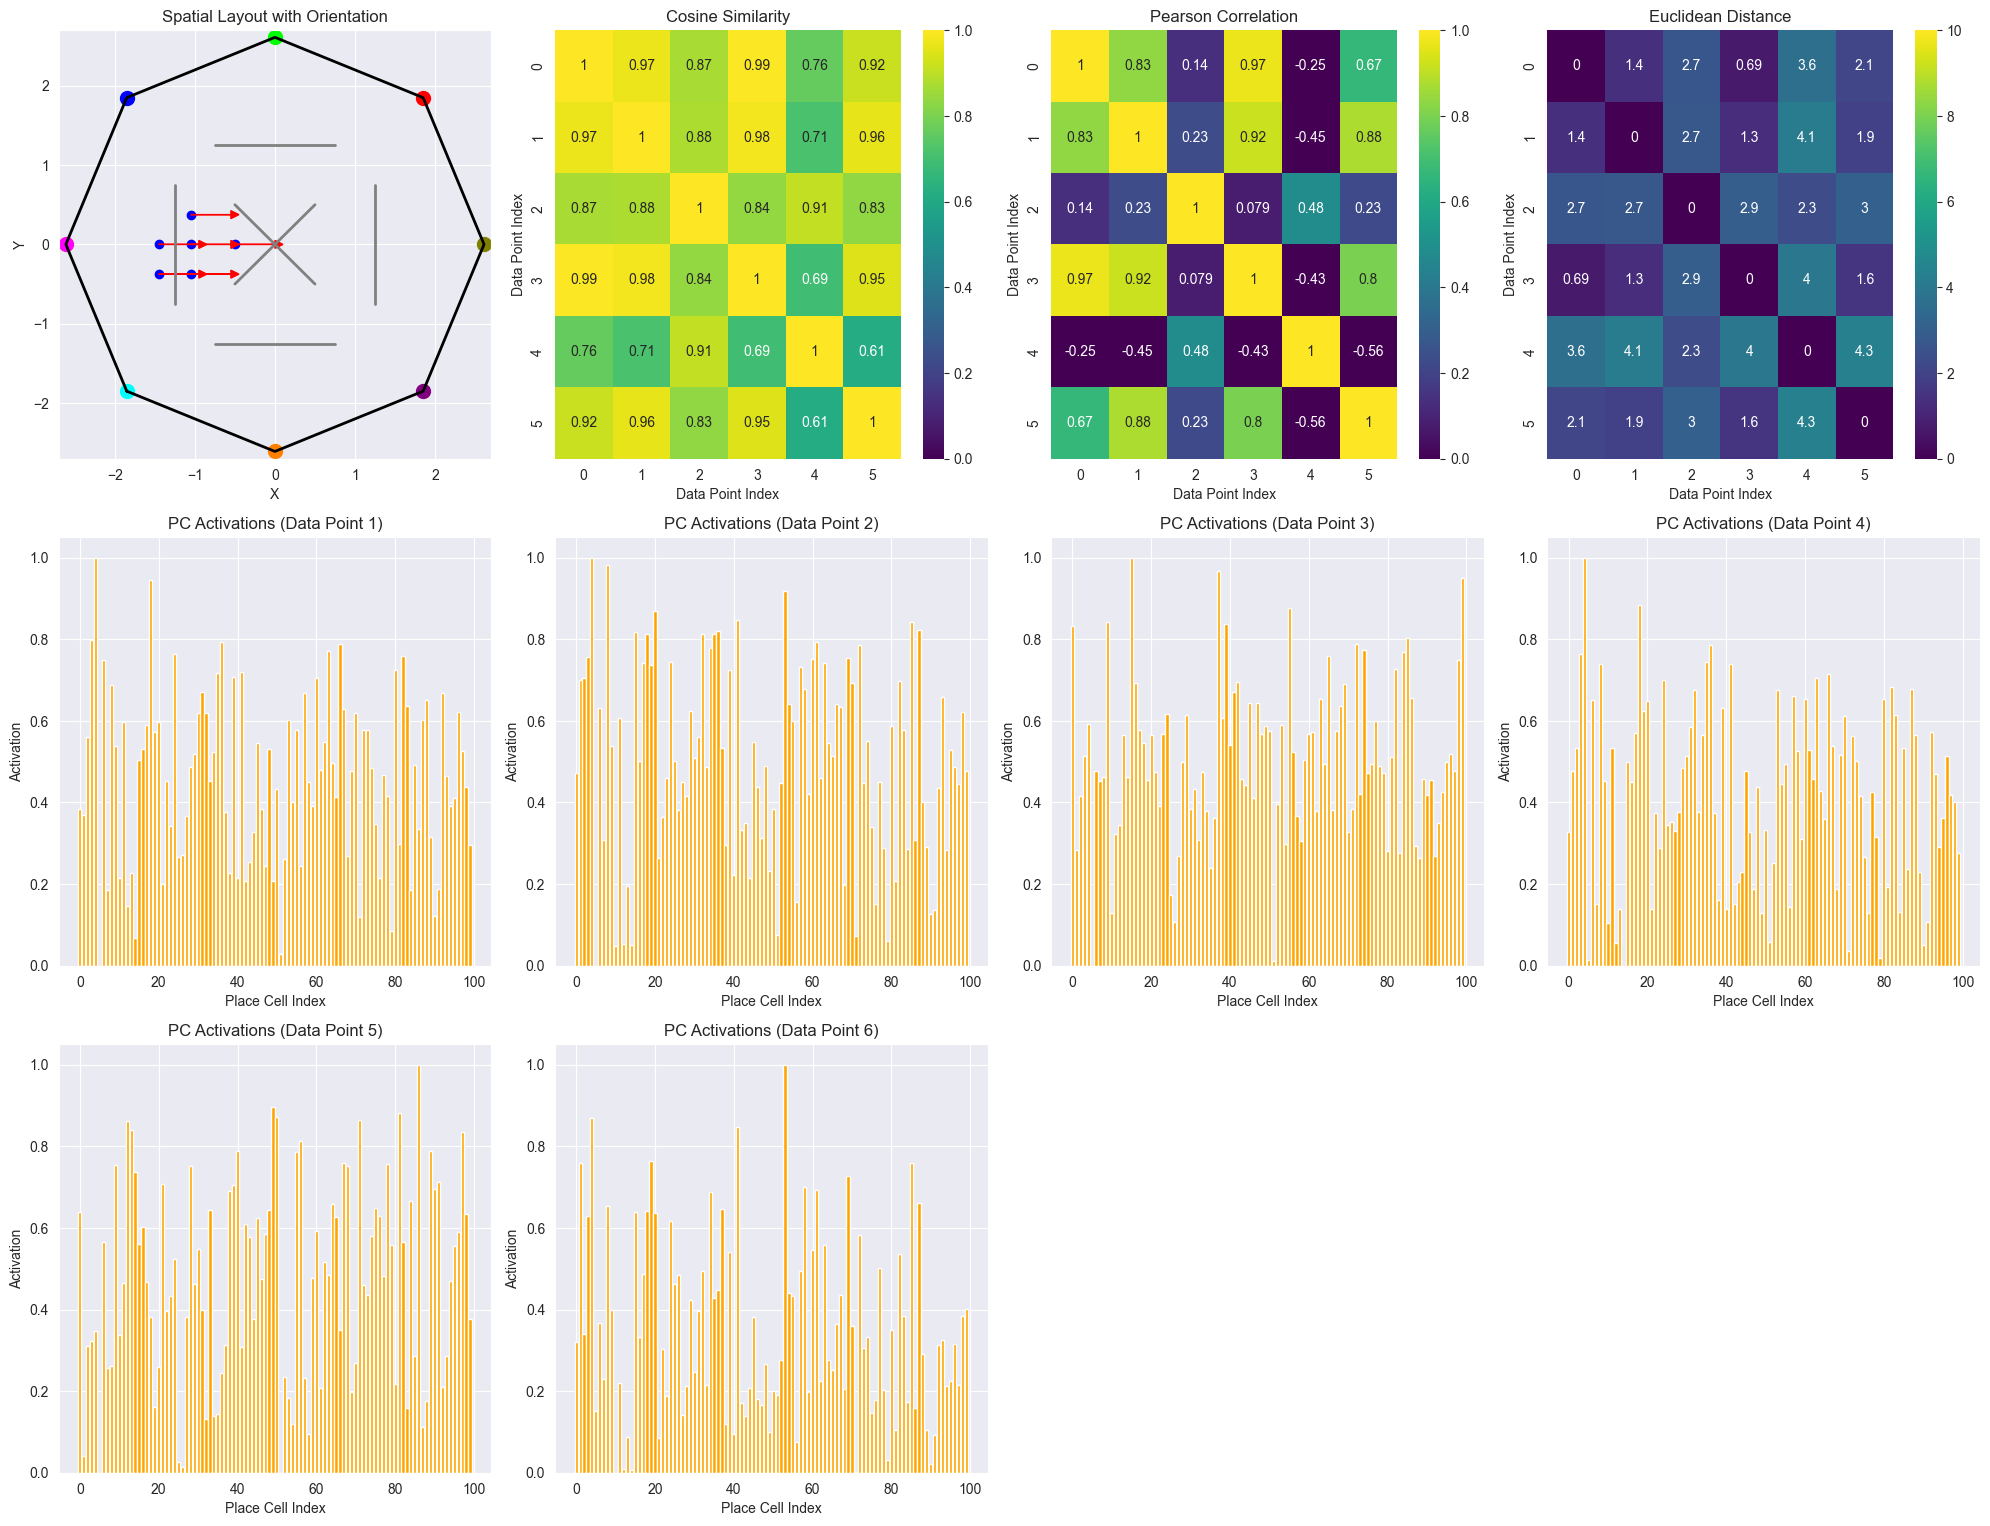

In [26]:
test = select_knn_with_orientation(grouped_data, 0, 6,mode=modes[0],point=(-2,.2))
calculate_and_visualize_similarity(test,pc_network,feature_type='multimodal',landmarks=landmarks,walls=walls)

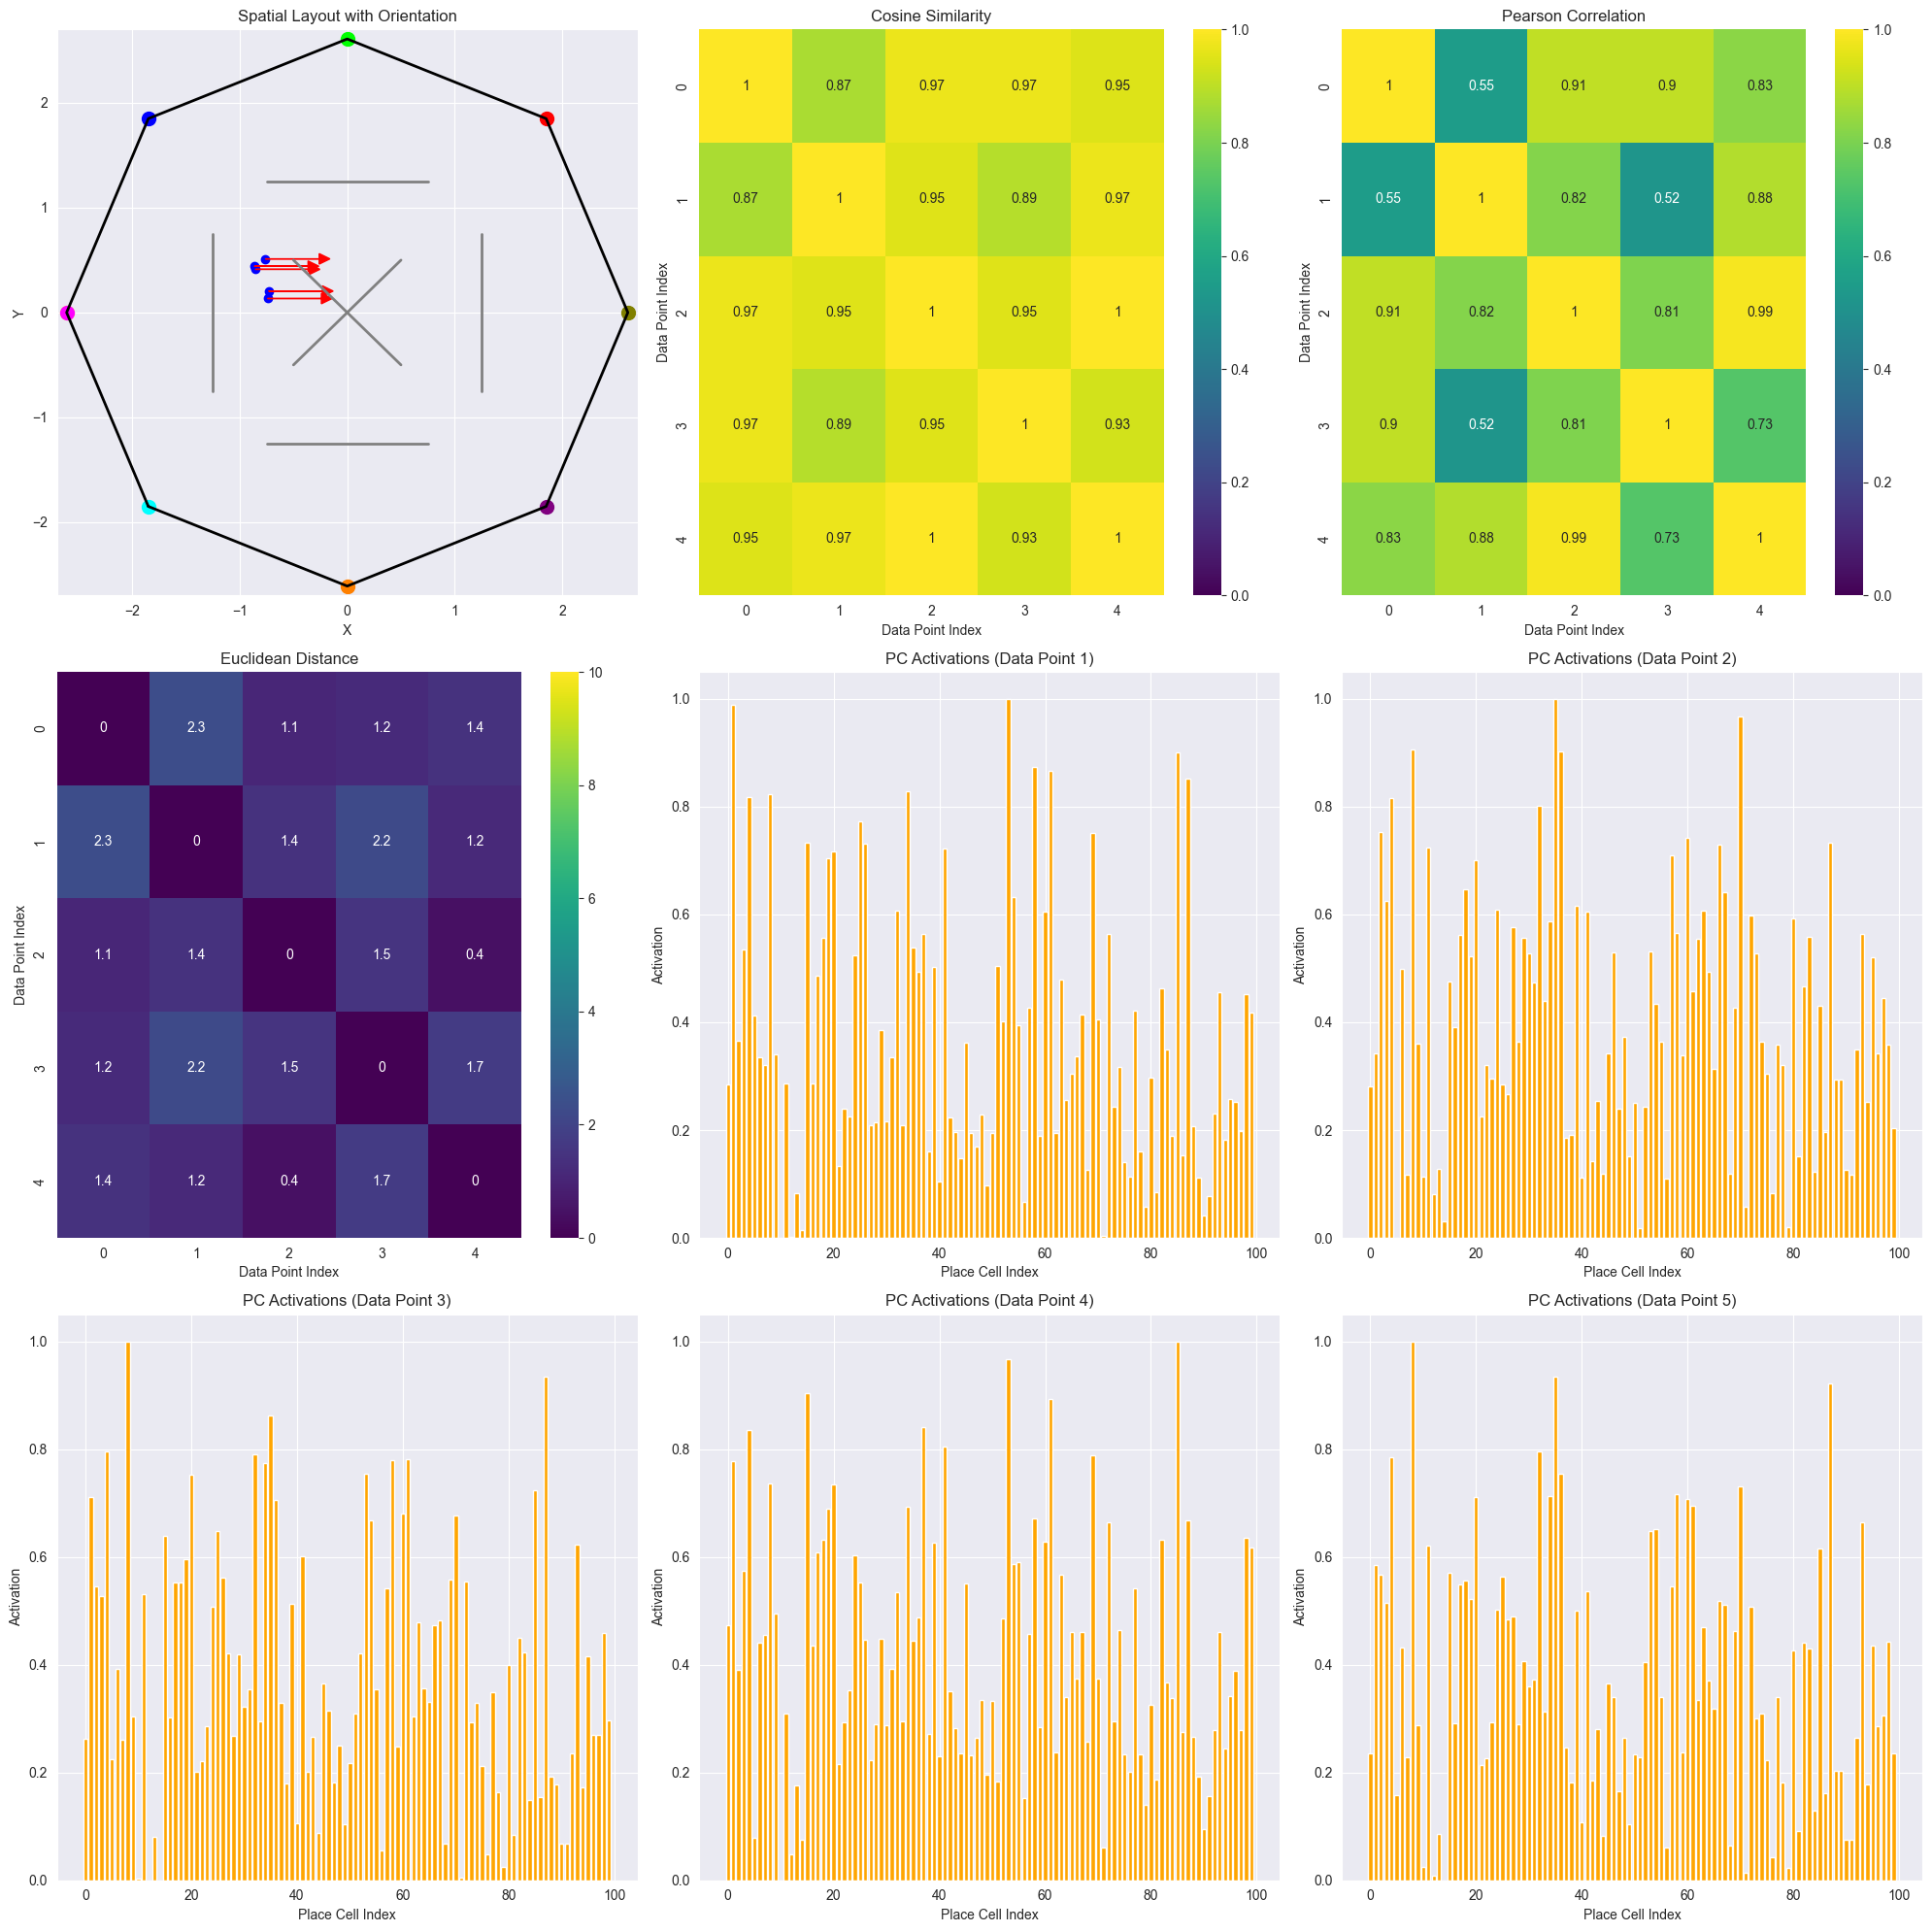

In [32]:
test = select_knn_with_orientation(grouped_data, 0, 5,mode=modes[0],point=(-.5,.2))
calculate_and_visualize_similarity(test,pc_network,feature_type='multimodal',landmarks=landmarks,walls=walls)

In [27]:
def group_dataset_for_wall_comparison(dataset, walls):
    """
    Groups the dataset by wall, side, and theta for comparison.

    Parameters:
    - dataset: An object with an 'observations' attribute, which is a list of observations.
               Each observation should have 'x', 'y', and 'theta' attributes.
    - walls: List of tuples representing walls. Each tuple is ((x1, y1), (x2, y2)).

    Returns:
    - dict: A nested dictionary structured as:
        {
            wall_number: {
                'side_1': {
                    theta: [points]
                },
                'side_2': {
                    theta: [points]
                }
            }
        }
    """
    grouped_data = defaultdict(lambda: {
        'side_1': defaultdict(list),
        'side_2': defaultdict(list)
    })

    # Group by theta using the existing function
    theta_groups = group_dataset_by_theta(dataset)

    # Handle all walls consistently (including walls 5 and 6)
    for wall_num, ((x1, y1), (x2, y2)) in enumerate(walls, start=1):
        for theta, points in theta_groups.items():
            # Number of points to select per side:
            if wall_num <= 4:
                num_points_per_side = 3
            else:
                num_points_per_side = 2

            # Calculate the distance of each point to the wall
            side_1_candidates = []
            side_2_candidates = []

            for point in points:
                a = y2 - y1
                b = x1 - x2
                c = x2 * y1 - x1 * y2
                side_value = a * point.x + b * point.y + c

                # Compute perpendicular distance to the wall
                distance = abs(a * point.x + b * point.y + c) / np.sqrt(a**2 + b**2)

                if side_value > 0:
                    side_1_candidates.append((point, distance))
                else:
                    side_2_candidates.append((point, distance))

            # Sort by distance and take the closest points
            side_1_candidates = sorted(side_1_candidates, key=lambda x: x[1])[:num_points_per_side]
            side_2_candidates = sorted(side_2_candidates, key=lambda x: x[1])[:num_points_per_side]

            # Add to grouped data
            for point, _ in side_1_candidates:
                grouped_data[f'wall_{wall_num}']['side_1'][theta].append(point)
            for point, _ in side_2_candidates:
                grouped_data[f'wall_{wall_num}']['side_2'][theta].append(point)

    return grouped_data


In [28]:
grouped_data = group_dataset_for_wall_comparison(test_data,walls)

In [29]:
def plot_split_data(grouped_data, walls, landmarks, theta):
    """
    Plots the split data into subplots, one for each wall, including walls, landmarks, and side data.

    Parameters:
    - grouped_data: Nested dictionary with structure {wall -> side -> theta -> points}.
    - walls: List of tuples representing walls. Each tuple is ((x1, y1), (x2, y2)).
    - landmarks: List of tuples representing landmarks with format (x, y, (r, g, b)).
    - theta: Fixed theta value to plot points for.
    """
    num_walls = len(walls)
    num_cols = 3
    num_rows = (num_walls + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()

    # Sort landmarks based on their angle from the center (to create an octagon)
    landmark_positions = [(x, y) for (x, y, _) in landmarks]
    landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))

    # Step 1: Loop over each wall
    for i, ((x1, y1), (x2, y2)) in enumerate(walls):
        ax = axes[i]
        
        # Step 2: Plot the landmarks
        for (x, y, (r, g, b)) in landmarks:
            ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black')
        
        # Draw the octagon by connecting adjacent landmarks
        for j in range(len(landmark_positions)):
            x_start, y_start = landmark_positions[j]
            x_end, y_end = landmark_positions[(j + 1) % len(landmark_positions)]  # Wrap around to close the shape
            ax.plot([x_start, x_end], [y_start, y_end], color='gray', linewidth=1)

        # Step 3: Plot all walls in gray, highlight the active wall in red
        for j, ((wx1, wy1), (wx2, wy2)) in enumerate(walls):
            color = 'gray' if i != j else 'red'
            ax.plot([wx1, wx2], [wy1, wy2], color=color, linewidth=2)

        # Step 4: Plot the data points for the current wall
        wall_key = f'wall_{i + 1}'
        if wall_key in grouped_data:
            if 'side_1' in grouped_data[wall_key] and theta in grouped_data[wall_key]['side_1']:
                side_1_points = grouped_data[wall_key]['side_1'][theta]
                x_side_1 = [p.x for p in side_1_points]
                y_side_1 = [p.y for p in side_1_points]
                ax.scatter(x_side_1, y_side_1, color='blue', label='Side 1', s=30)

            if 'side_2' in grouped_data[wall_key] and theta in grouped_data[wall_key]['side_2']:
                side_2_points = grouped_data[wall_key]['side_2'][theta]
                x_side_2 = [p.x for p in side_2_points]
                y_side_2 = [p.y for p in side_2_points]
                ax.scatter(x_side_2, y_side_2, color='green', label='Side 2', s=30)

        # Set plot limits and labels
        ax.set_xlim(-2.7, 2.7)
        ax.set_ylim(-2.7, 2.7)
        ax.set_title(f'Wall {i + 1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()

    plt.tight_layout()
    plt.show()


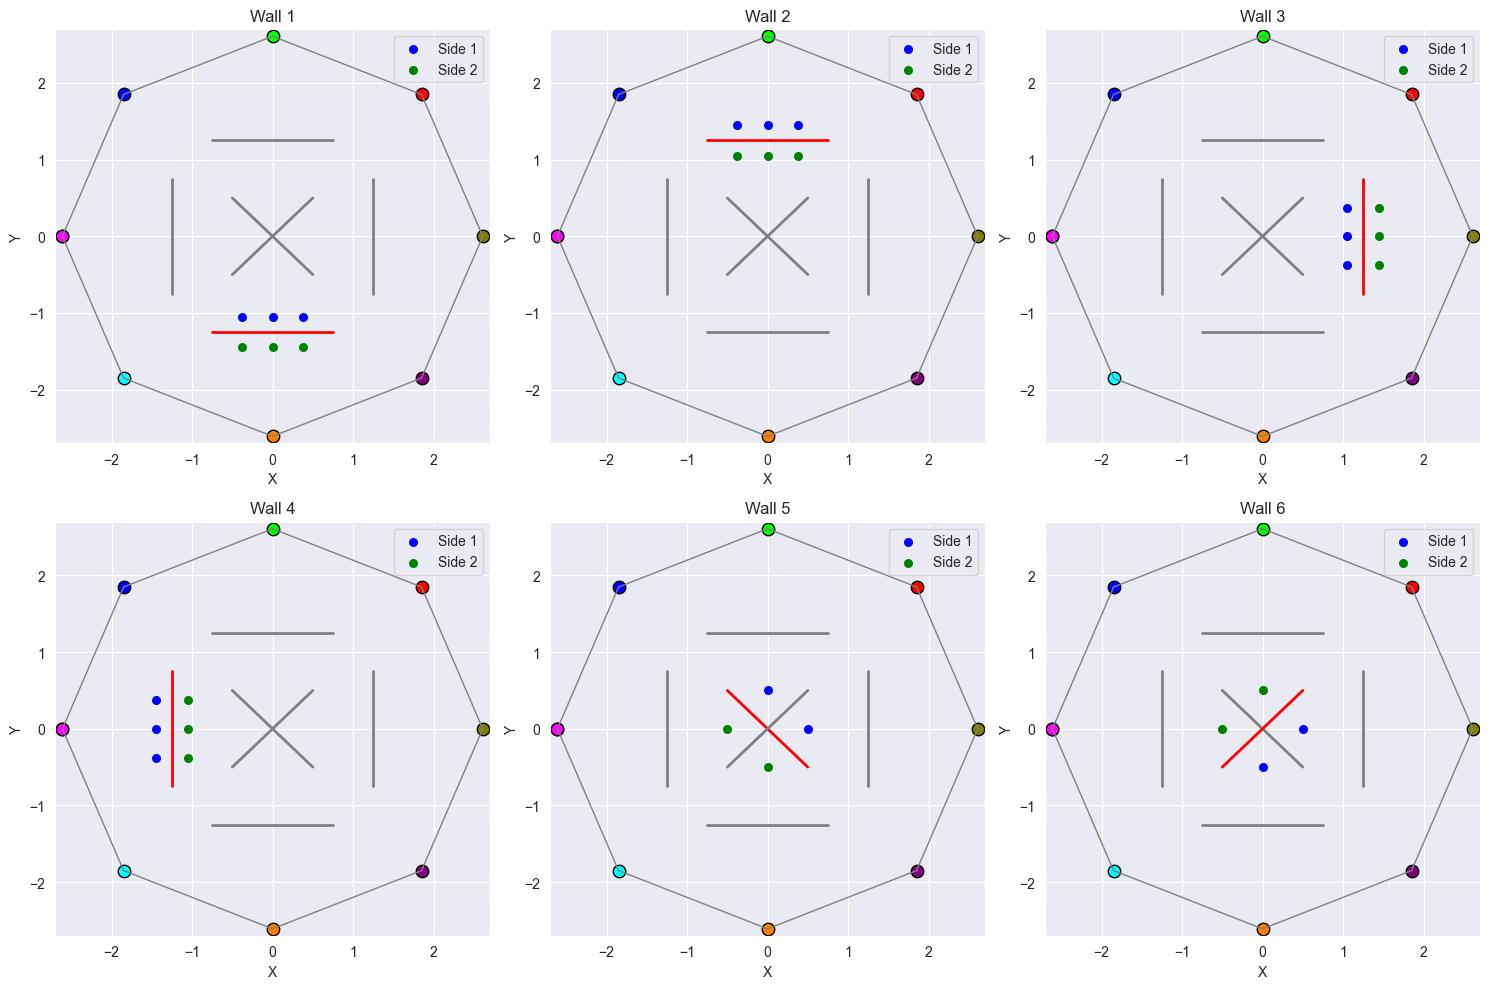

In [30]:
plot_split_data(grouped_data,walls,landmarks, 0)

In [31]:
def calculate_and_visualize_wall_similarity(grouped_data, pc_network, wall_num, theta_index, landmarks, walls):
    """
    Calculate and visualize similarity metrics for place cell activations from points on both sides of a specific wall.

    Parameters:
    - grouped_data: dict, structured wall data from grouping function.
    - pc_network: object, place cell network for activation calculation.
    - wall_num: int, wall number to analyze.
    - theta: float, fixed theta value to select points from.
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.
    - walls: list of tuples representing walls [(x1, y1), (x2, y2)].

    Returns:
    - None, but displays the combined visualization.
    """
    wall_key = f'wall_{wall_num}'
    if wall_key not in grouped_data:
        raise ValueError(f"Wall {wall_num} not found in the data")
    thetas = [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793, 3.9269908169872414, 4.71238898038469, 5.497787143782138]
    theta = thetas[theta_index]
    side_1_points = grouped_data[wall_key]['side_1'].get(theta, [])
    side_2_points = grouped_data[wall_key]['side_2'].get(theta, [])

    num_points = len(side_1_points) + len(side_2_points)

    if num_points == 0:
        raise ValueError(f"No data points available for wall {wall_num} at theta {theta}")

    # Step 1: Create layout (square layout)
    num_cols = 4
    num_rows = max(3, (num_points + num_cols - 1) // num_cols) + 2  # Add room for heatmaps

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()

    # Step 2: Spatial plot
    spatial_ax = axes[0]

    # Plot the landmarks
    landmark_positions = [(x, y) for (x, y, _) in landmarks]
    landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))
    for (x, y, (r, g, b)) in landmarks:
        spatial_ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black')
    
    # Draw octagon connecting the landmarks
    for i in range(len(landmark_positions)):
        x1, y1 = landmark_positions[i]
        x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
        spatial_ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)

    # Plot all walls in gray, highlight the current wall in red
    for i, ((x1, y1), (x2, y2)) in enumerate(walls):
        color = 'gray' if i + 1 != wall_num else 'red'
        spatial_ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    # Plot side 1 points in blue with orientation vector
    for p in side_1_points:
        spatial_ax.scatter(p.x, p.y, color='blue', label='Side 1', s=30)
        # theta_rad = np.deg2rad(p.theta)
        dx = 0.3 * np.cos(p.theta)
        dy = 0.3 * np.sin(p.theta)
        spatial_ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

    # Plot side 2 points in green with orientation vector
    for p in side_2_points:
        spatial_ax.scatter(p.x, p.y, color='green', label='Side 2', s=30)
        # theta_rad = np.deg2rad(p.theta)
        dx = 0.3 * np.cos(p.theta)
        dy = 0.3 * np.sin(p.theta)
        spatial_ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='green', ec='green')

    spatial_ax.set_xlim([-2.7, 2.7])
    spatial_ax.set_ylim([-2.7, 2.7])
    spatial_ax.set_title(f"Wall {wall_num} - Spatial Layout")
    spatial_ax.set_xlabel("X")
    spatial_ax.set_ylabel("Y")

    # Step 3: Calculate similarity metrics
    all_points = side_1_points + side_2_points
    activation_vectors = []
    
    for p in all_points:
        activations = pc_network.get_all_pc_activations_normalized(p.multimodal_feature_vector, norm_type='min_max')
        activation_vectors.append(activations)

    activation_vectors = np.array(activation_vectors)

    # Cosine similarity, Pearson correlation, Euclidean distance
    cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
    euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
    n = len(pc_network.pc_list)
    euclidean_scale = np.sqrt(n)

    pearson_corr_matrix = np.zeros((len(activation_vectors), len(activation_vectors)))
    for i in range(len(activation_vectors)):
        for j in range(len(activation_vectors)):
            if i != j:
                pearson_corr_matrix[i, j], _ = pearsonr(activation_vectors[i], activation_vectors[j])
            else:
                pearson_corr_matrix[i, j] = 1

    # Step 4: Plot similarity heatmaps
    heatmap_titles = ['Cosine Similarity', 'Pearson Correlation', 'Euclidean Distance']
    similarity_matrices = [cosine_sim_matrix, pearson_corr_matrix, euclidean_dist_matrix]
    heatmap_scales = [(0, 1), (0, 1), (0, euclidean_scale)]

    for idx, (matrix, title, scale) in enumerate(zip(similarity_matrices, heatmap_titles, heatmap_scales)):
        ax = axes[idx + 1]
        sns.heatmap(matrix, ax=ax, cmap='viridis', annot=True, vmin=scale[0], vmax=scale[1])
        ax.set_title(title)
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

        # Add a divider to indicate side 1 vs side 2
        if len(side_1_points) > 0 and len(side_2_points) > 0:
            ax.axhline(len(side_1_points), color='red', lw=2)
            ax.axvline(len(side_1_points), color='red', lw=2)

    # Step 5: Activation plots
    for i, activations in enumerate(activation_vectors):
        ax = axes[len(similarity_matrices) + i + 1]
        ax.bar(range(len(activations)), activations, color='orange')
        ax.set_title(f'PC Activations (Data Point {i + 1})')
        ax.set_xlabel('Place Cell Index')
        ax.set_ylabel('Activation')

    # Remove any unused axes
    for i in range(len(similarity_matrices) + num_points + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [32]:
def visualize_wall_similarity(grouped_data, pc_network, wall_num, theta_list, landmarks, walls):
    """
    Visualize similarity metrics for place cell activations across different theta values.

    Parameters:
    - grouped_data: dict, structured wall data from grouping function.
    - pc_network: object, place cell network for activation calculation.
    - wall_num: int, wall number to analyze.
    - theta_list: list of float, theta values to visualize.
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.
    - walls: list of tuples representing walls [(x1, y1), (x2, y2)].

    Returns:
    - None, but displays the combined visualization.
    """
    wall_key = f'wall_{wall_num}'
    if wall_key not in grouped_data:
        raise ValueError(f"Wall {wall_num} not found in the data")

    num_thetas = len(theta_list)
    num_cols = 4
    num_rows = num_thetas

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle(f"Wall {wall_num} - Similarity Metrics Across Thetas", fontsize=16)

    for row, theta in enumerate(theta_list):
        side_1_points = grouped_data[wall_key]['side_1'].get(theta, [])
        side_2_points = grouped_data[wall_key]['side_2'].get(theta, [])

        num_points = len(side_1_points) + len(side_2_points)
        if num_points == 0:
            continue

        # Step 1: Spatial Plot
        ax = axes[row, 0]
        landmark_positions = [(x, y) for (x, y, _) in landmarks]
        landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))

        for (x, y, (r, g, b)) in landmarks:
            ax.scatter(x, y, color=(r, g, b), s=80, edgecolor='black')

        # Connect landmarks to form an octagon
        for i in range(len(landmark_positions)):
            x1, y1 = landmark_positions[i]
            x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)

        # Plot walls
        for i, ((x1, y1), (x2, y2)) in enumerate(walls):
            color = 'gray' if i + 1 != wall_num else 'red'
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

        # Plot data points and orientation
        for p in side_1_points:
            ax.scatter(p.x, p.y, color='blue', label='Side 1', s=30)
            dx = 0.3 * np.cos(p.theta)
            dy = 0.3 * np.sin(p.theta)
            ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

        for p in side_2_points:
            ax.scatter(p.x, p.y, color='green', label='Side 2', s=30)
            dx = 0.3 * np.cos(p.theta)
            dy = 0.3 * np.sin(p.theta)
            ax.arrow(p.x, p.y, dx, dy, head_width=0.1, head_length=0.1, fc='green', ec='green')

        ax.set_xlim([-2.7, 2.7])
        ax.set_ylim([-2.7, 2.7])
        ax.set_title(f'Theta: {theta:.2f} - Spatial Plot')

        # Step 2: Calculate similarity metrics
        all_points = side_1_points + side_2_points
        activation_vectors = [pc_network.get_all_pc_activations_normalized(p.multimodal_feature_vector, norm_type='min_max')
                              for p in all_points]

        activation_vectors = np.array(activation_vectors)

        cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
        euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
        n = len(pc_network.pc_list)
        euclidean_scale = np.sqrt(n)

        pearson_corr_matrix = np.zeros((len(activation_vectors), len(activation_vectors)))
        for i in range(len(activation_vectors)):
            for j in range(len(activation_vectors)):
                if i != j:
                    pearson_corr_matrix[i, j], _ = pearsonr(activation_vectors[i], activation_vectors[j])
                else:
                    pearson_corr_matrix[i, j] = 1

        # Step 3: Cosine Similarity Heatmap
        ax = axes[row, 1]
        sns.heatmap(cosine_sim_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=1)
        ax.set_title('Cosine Similarity')

        # Step 4: Pearson Correlation Heatmap
        ax = axes[row, 2]
        sns.heatmap(pearson_corr_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=1)
        ax.set_title('Pearson Correlation')

        # Step 5: Euclidean Distance Heatmap
        ax = axes[row, 3]
        sns.heatmap(euclidean_dist_matrix, ax=ax, cmap='viridis', annot=True, vmin=0, vmax=euclidean_scale)
        ax.set_title('Euclidean Distance')

        # Draw red lines to distinguish sides
        if len(side_1_points) > 0 and len(side_2_points) > 0:
            for ax in [axes[row, 1], axes[row, 2], axes[row, 3]]:
                ax.axhline(len(side_1_points), color='red', lw=2)
                ax.axvline(len(side_1_points), color='red', lw=2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example call:
# theta_list = [0.0, 1.5708, 3.1416]
# visualize_wall_similarity(grouped_data, pc_network, wall_num=1, theta_list=theta_list, landmarks=landmarks, walls=walls)


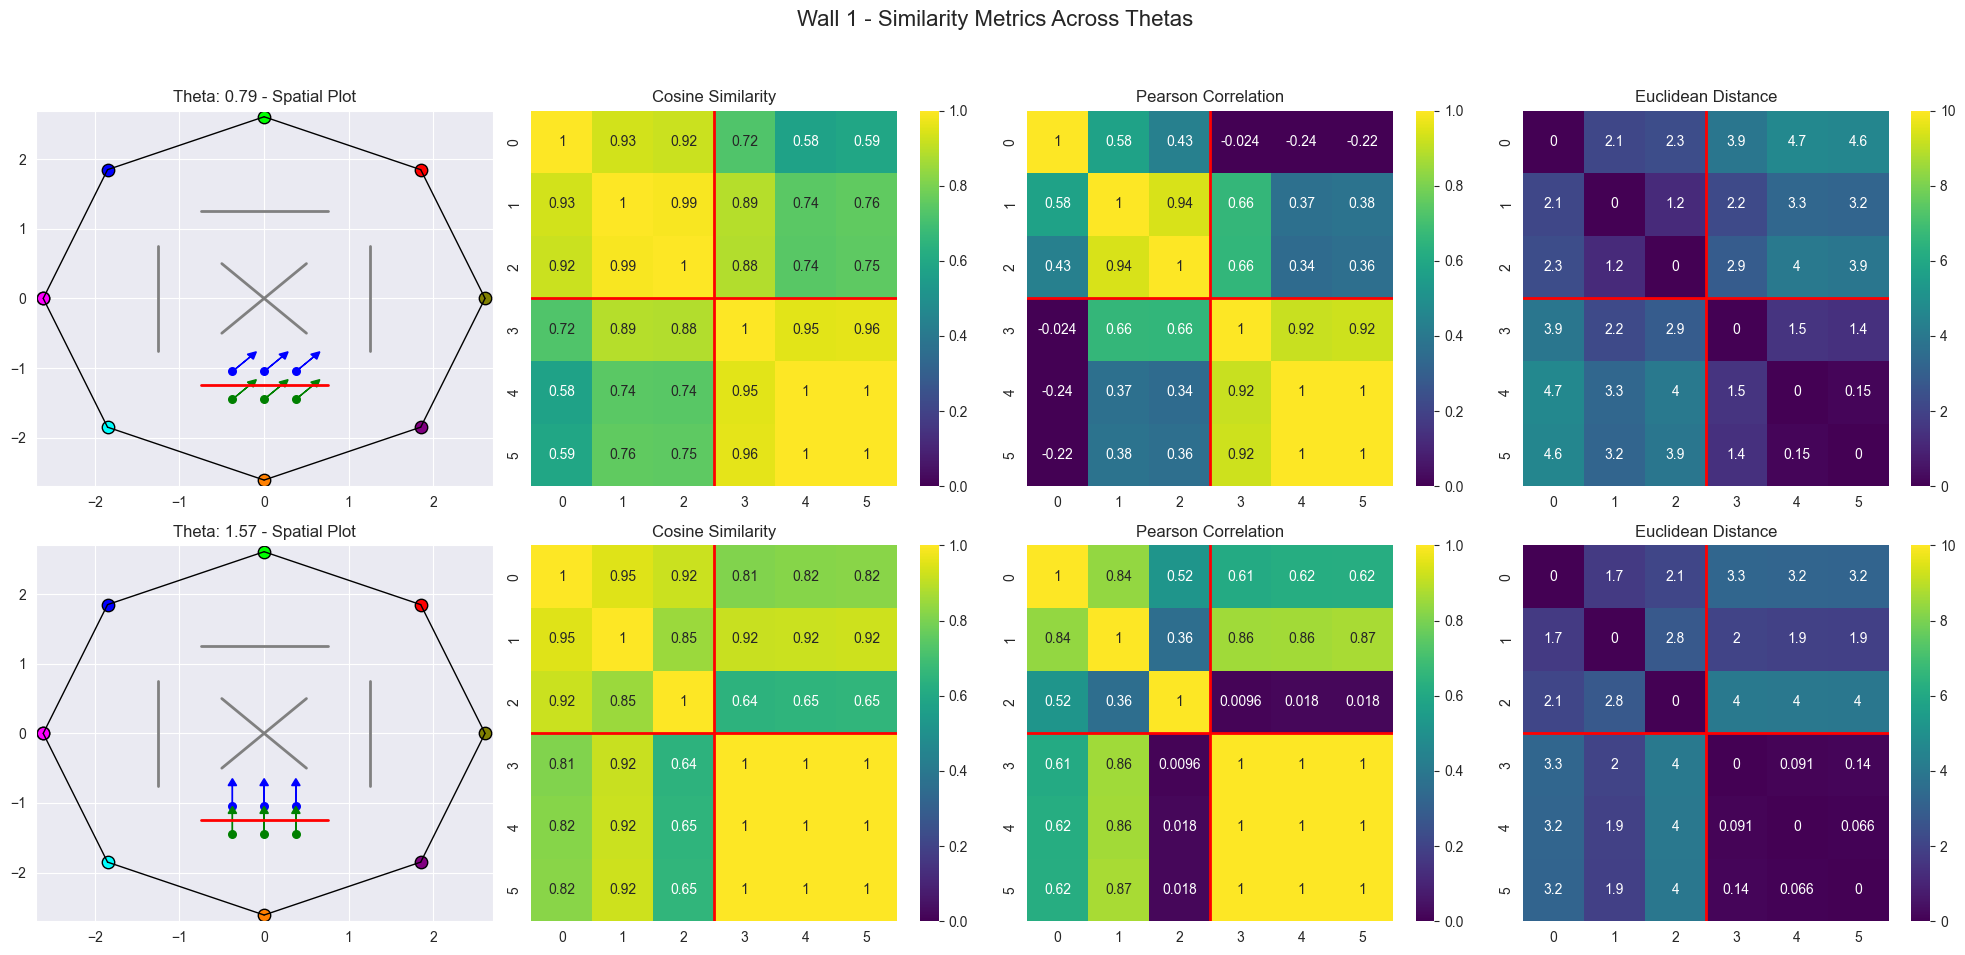

In [17]:
theta_list = [thetas[1],thetas[2]]
visualize_wall_similarity(grouped_data, pc_network, wall_num=1, theta_list=theta_list, landmarks=landmarks, walls=walls)

# Best Examples

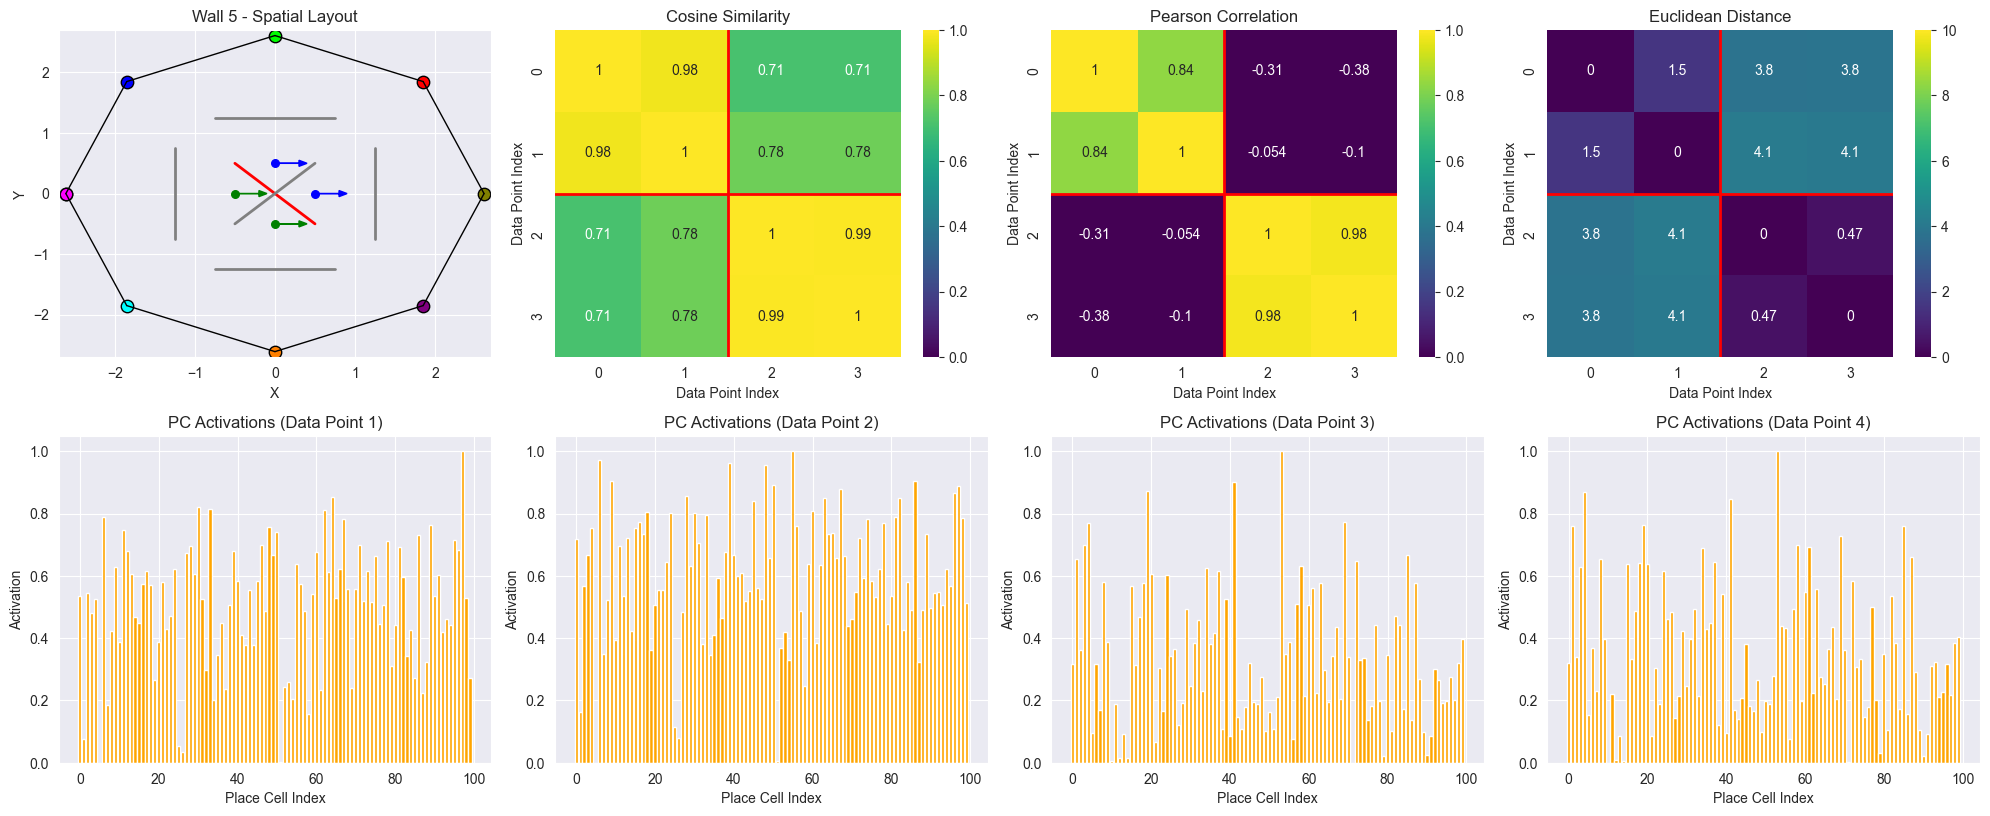

In [36]:
calculate_and_visualize_wall_similarity(grouped_data,pc_network,5,0,landmarks,walls)

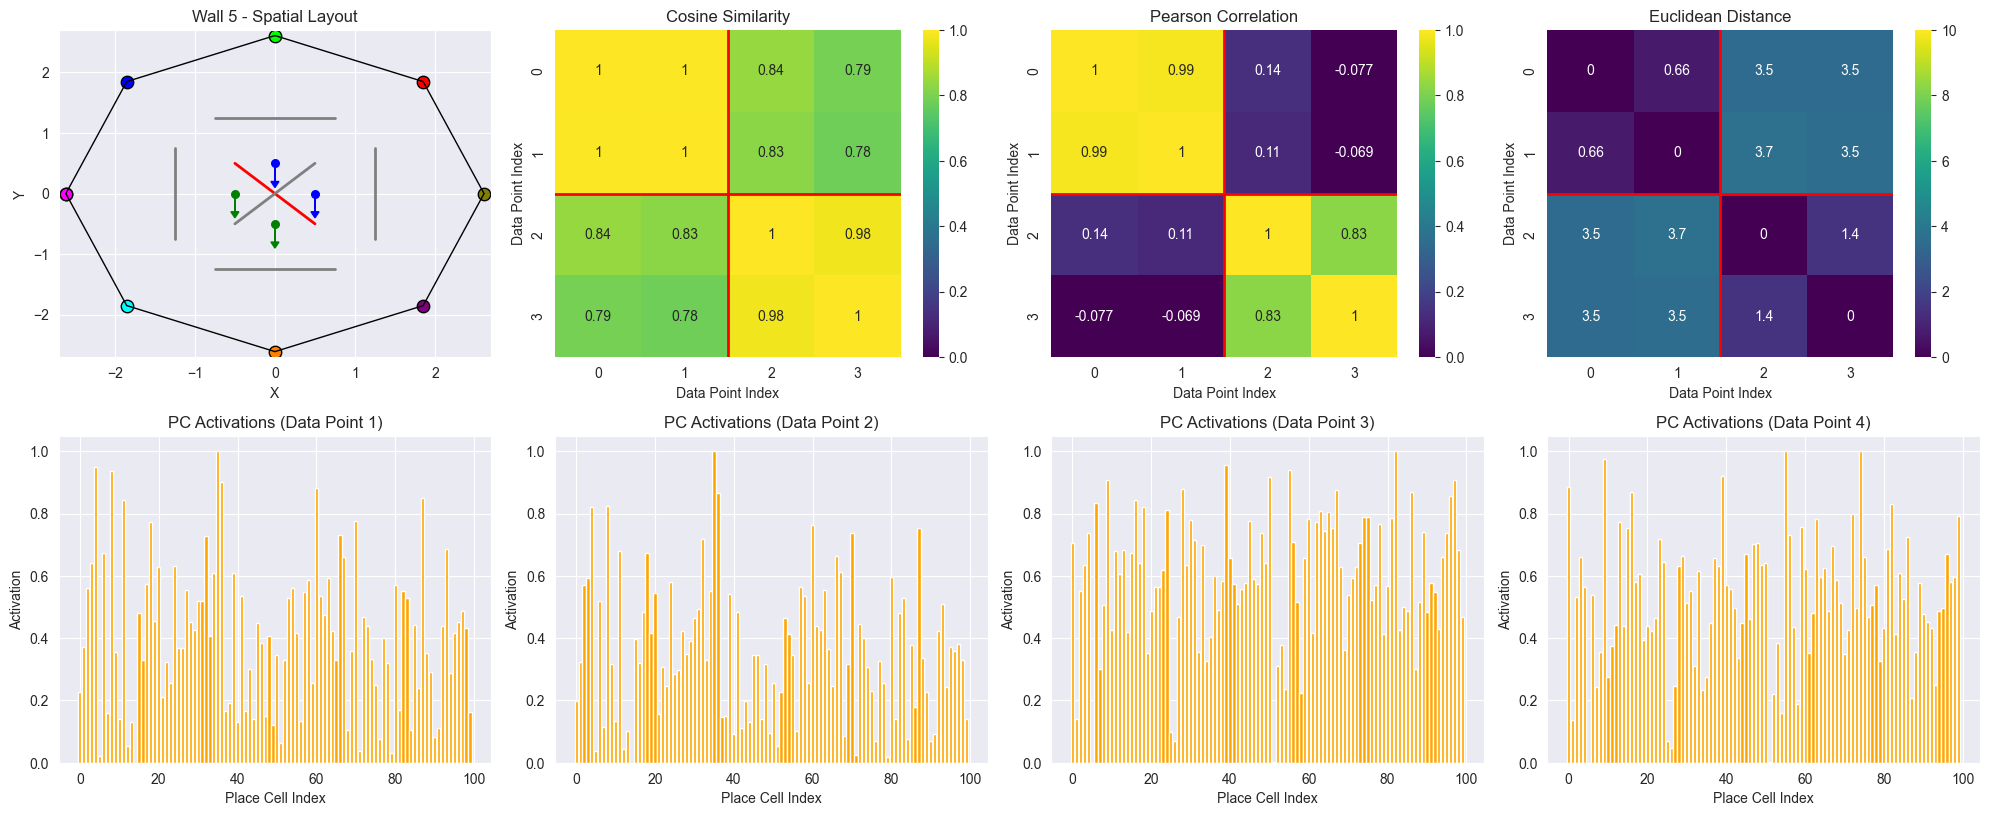

In [38]:
calculate_and_visualize_wall_similarity(grouped_data,pc_network,5,6,landmarks,walls)

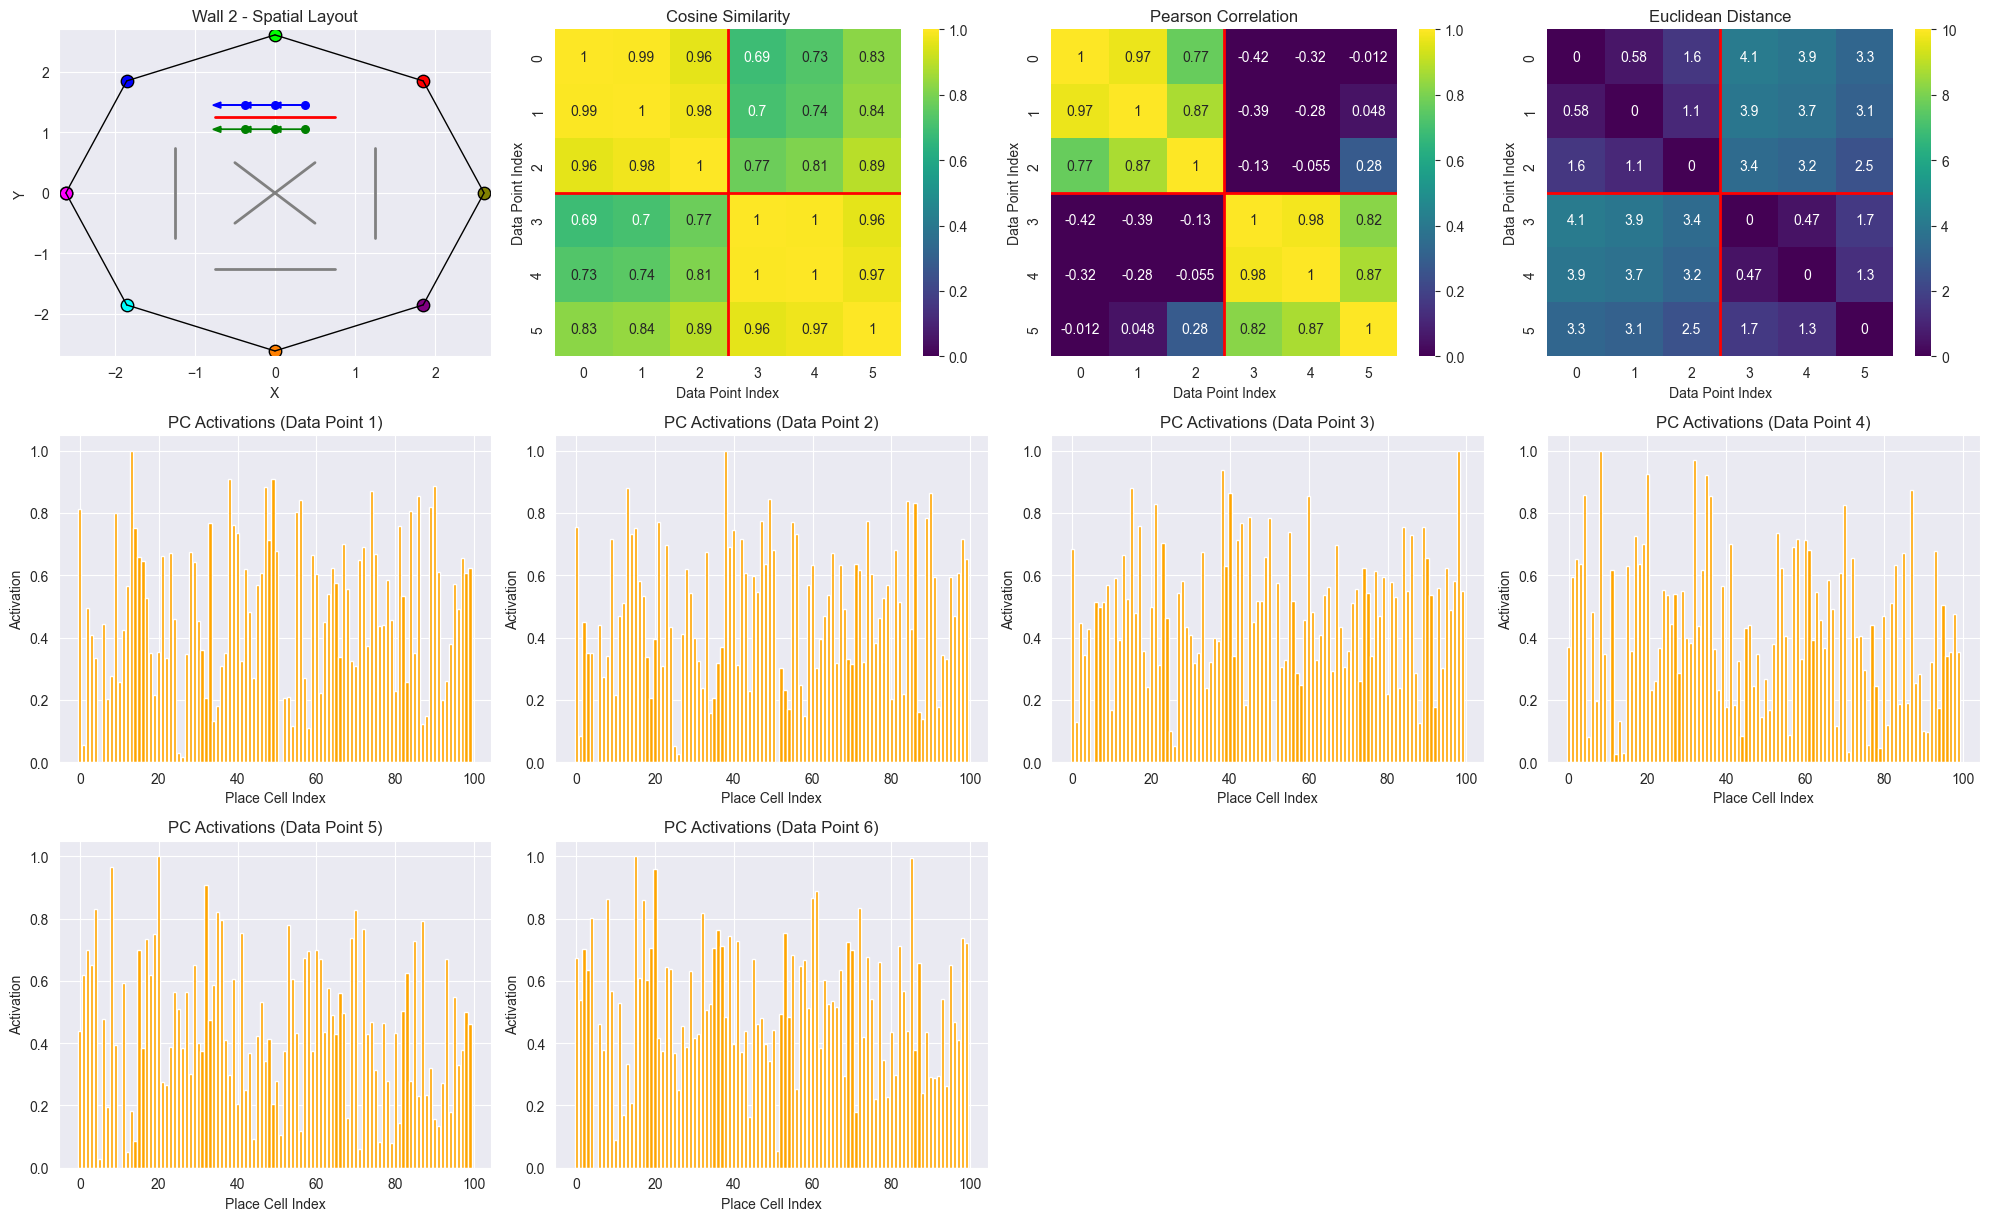

In [24]:
calculate_and_visualize_wall_similarity(grouped_data,pc_network,2,4,landmarks,walls)

# Statistic Analysis

In [33]:
def calculate_similarity_metrics(activation_1, activation_2):
    """
    Calculate similarity metrics between two place cell activation vectors.

    Parameters:
    - activation_1: np.array, first place cell activation vector.
    - activation_2: np.array, second place cell activation vector.

    Returns:
    - cos_sim: float, cosine similarity between activation_1 and activation_2.
    - pearson_corr: float, Pearson correlation coefficient between activation_1 and activation_2.
    - dist: float, Euclidean distance between activation_1 and activation_2.
    """
    # Cosine similarity (1 - cosine distance because higher value means more similar)
    cos_sim = 1 - cosine(activation_1, activation_2)

    # Pearson correlation (returns NaN if the variance of either vector is zero)
    try:
        pearson_corr, _ = pearsonr(activation_1, activation_2)
    except Exception:
        pearson_corr = np.nan

    # Euclidean distance
    dist = euclidean(activation_1, activation_2)

    return cos_sim, pearson_corr, dist


In [34]:
def collect_similarity_metrics(grouped_data, pc_network):
    """
    Collect similarity metrics for same-side and different-side data points.

    Parameters:
    - grouped_data: dict, data structured as {wall: {side: {theta: [data points]}}}
    - pc_network: object, the place cell network used to get activations.

    Returns:
    - same_side_metrics: list of (cos_sim, pearson_corr, dist) for same-side pairs.
    - diff_side_metrics: list of (cos_sim, pearson_corr, dist) for different-side pairs.
    """
    same_side_metrics = []
    diff_side_metrics = []

    total_comparisons = sum(
        len(side_1) * (len(side_1) - 1) // 2 +  # Same-side pairs within side 1
        len(side_2) * (len(side_2) - 1) // 2 +  # Same-side pairs within side 2
        len(side_1) * len(side_2)               # Cross-side pairs
        for wall in grouped_data
        for side_1 in grouped_data[wall].get('side_1', {}).values()
        for side_2 in grouped_data[wall].get('side_2', {}).values()
    )

    with tqdm(total=total_comparisons, desc="Calculating Similarity") as pbar:
        for wall in grouped_data.keys():
            sides = list(grouped_data[wall].keys())

            if len(sides) != 2:
                continue

            side_1_points = grouped_data[wall][sides[0]]
            side_2_points = grouped_data[wall][sides[1]]

            for theta in side_1_points.keys():
                if theta not in side_2_points:
                    continue

                points_side_1 = side_1_points[theta]
                points_side_2 = side_2_points[theta]

                # Compare all pairs within side 1
                for i in range(len(points_side_1)):
                    for j in range(i + 1, len(points_side_1)):
                        activation_1 = pc_network.get_all_pc_activations_normalized(
                            points_side_1[i].multimodal_feature_vector, norm_type='min_max'
                        )
                        activation_2 = pc_network.get_all_pc_activations_normalized(
                            points_side_1[j].multimodal_feature_vector, norm_type='min_max'
                        )
                        same_side_metrics.append(calculate_similarity_metrics(activation_1, activation_2))
                        pbar.update(1)

                # Compare all pairs within side 2
                for i in range(len(points_side_2)):
                    for j in range(i + 1, len(points_side_2)):
                        activation_1 = pc_network.get_all_pc_activations_normalized(
                            points_side_2[i].multimodal_feature_vector, norm_type='min_max'
                        )
                        activation_2 = pc_network.get_all_pc_activations_normalized(
                            points_side_2[j].multimodal_feature_vector, norm_type='min_max'
                        )
                        same_side_metrics.append(calculate_similarity_metrics(activation_1, activation_2))
                        pbar.update(1)

                # Compare pairs across side 1 and side 2 (same theta)
                for i in range(len(points_side_1)):
                    for j in range(len(points_side_2)):
                        activation_1 = pc_network.get_all_pc_activations_normalized(
                            points_side_1[i].multimodal_feature_vector, norm_type='min_max'
                        )
                        activation_2 = pc_network.get_all_pc_activations_normalized(
                            points_side_2[j].multimodal_feature_vector, norm_type='min_max'
                        )
                        diff_side_metrics.append(calculate_similarity_metrics(activation_1, activation_2))
                        pbar.update(1)

    return same_side_metrics, diff_side_metrics


In [35]:
def test_significance(same_side_metrics, diff_side_metrics):
    """
    Perform significance tests on similarity metrics between same-side and different-side data.

    Parameters:
    - same_side_metrics: list of (cos_sim, pearson_corr, dist) for same-side pairs.
    - diff_side_metrics: list of (cos_sim, pearson_corr, dist) for different-side pairs.

    Returns:
    - results: dict containing t-test and Mann-Whitney test results for each metric.
    """
    results = {}

    # Separate metrics
    same_side_cos_sim = [x[0] for x in same_side_metrics]
    diff_side_cos_sim = [x[0] for x in diff_side_metrics]
    
    same_side_dist = [x[2] for x in same_side_metrics]
    diff_side_dist = [x[2] for x in diff_side_metrics]

    # Cosine Similarity Test
    # First test for normality
    normality_same_cos = shapiro(same_side_cos_sim).pvalue
    normality_diff_cos = shapiro(diff_side_cos_sim).pvalue

    if normality_same_cos > 0.05 and normality_diff_cos > 0.05:
        # If both sets are normal → Use t-test
        cos_t_stat, cos_p_value = ttest_ind(same_side_cos_sim, diff_side_cos_sim, alternative='greater')
    else:
        # If not normal → Use Mann-Whitney U test
        cos_t_stat, cos_p_value = mannwhitneyu(same_side_cos_sim, diff_side_cos_sim, alternative='greater')

    results['cosine_similarity'] = {
        'test_statistic': cos_t_stat,
        'p_value': cos_p_value,
        'test_used': 't-test' if normality_same_cos > 0.05 and normality_diff_cos > 0.05 else 'Mann-Whitney U'
    }

    # Euclidean Distance Test
    # First test for normality
    normality_same_dist = shapiro(same_side_dist).pvalue
    normality_diff_dist = shapiro(diff_side_dist).pvalue

    if normality_same_dist > 0.05 and normality_diff_dist > 0.05:
        # If both sets are normal → Use t-test
        dist_t_stat, dist_p_value = ttest_ind(same_side_dist, diff_side_dist, alternative='less')
    else:
        # If not normal → Use Mann-Whitney U test
        dist_t_stat, dist_p_value = mannwhitneyu(same_side_dist, diff_side_dist, alternative='less')

    results['euclidean_distance'] = {
        'test_statistic': dist_t_stat,
        'p_value': dist_p_value,
        'test_used': 't-test' if normality_same_dist > 0.05 and normality_diff_dist > 0.05 else 'Mann-Whitney U'
    }

    return results

In [36]:
same_side_metrics, diff_side_metrics = collect_similarity_metrics(grouped_data, pc_network)
results = test_significance(same_side_metrics, diff_side_metrics)

Calculating Similarity:  12%|█▎        | 576/4608 [00:38<04:26, 15.15it/s]


In [16]:
print(results)

{'cosine_similarity': {'test_statistic': 64682.0, 'p_value': 8.849052017584602e-39, 'test_used': 'Mann-Whitney U'}, 'euclidean_distance': {'test_statistic': 13407.0, 'p_value': 5.07211039775246e-41, 'test_used': 'Mann-Whitney U'}}


In [41]:
def plot_similarity_metrics(same_side_metrics, diff_side_metrics):
    """
    Create box plots for same-side and different-side similarity metrics.

    Parameters:
    - same_side_metrics: list of (cos_sim, pearson_corr, dist) for same-side pairs.
    - diff_side_metrics: list of (cos_sim, pearson_corr, dist) for different-side pairs.
    """
    # Separate the metrics
    same_side_cos_sim = [x[0] for x in same_side_metrics]
    diff_side_cos_sim = [x[0] for x in diff_side_metrics]
    same_side_dist = [x[2] for x in same_side_metrics]
    diff_side_dist = [x[2] for x in diff_side_metrics]

    # Create a dataframe for easier plotting
    data = {
        'Cosine Similarity': same_side_cos_sim + diff_side_cos_sim,
        'Euclidean Distance': same_side_dist + diff_side_dist,
        'Type': (['Same Side'] * len(same_side_cos_sim)) + (['Different Side'] * len(diff_side_cos_sim))
    }

    # Plot boxplots for Cosine Similarity
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Type', y='Cosine Similarity', data=data)
    plt.title('Cosine Similarity: Same Side vs Different Side')
    plt.xlabel('Comparison Type')
    plt.ylabel('Cosine Similarity')
    plt.show()

    # Plot boxplots for Euclidean Distance
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Type', y='Euclidean Distance', data=data)
    plt.title('Euclidean Distance: Same Side vs Different Side')
    plt.xlabel('Comparison Type')
    plt.ylabel('Euclidean Distance')
    plt.show()
    
def plot_combined_similarity_metrics(same_side_metrics, diff_side_metrics):
    """
    Create a single row with two box plots for same-side and different-side similarity metrics.

    Parameters:
    - same_side_metrics: list of (cos_sim, pearson_corr, dist) for same-side pairs.
    - diff_side_metrics: list of (cos_sim, pearson_corr, dist) for different-side pairs.
    """
    # Separate the metrics
    same_side_cos_sim = [x[0] for x in same_side_metrics]
    diff_side_cos_sim = [x[0] for x in diff_side_metrics]
    same_side_dist = [x[2] for x in same_side_metrics]
    diff_side_dist = [x[2] for x in diff_side_metrics]

    # Create a dataframe for plotting
    data = pd.DataFrame({
        'Cosine Similarity': same_side_cos_sim + diff_side_cos_sim,
        'Euclidean Distance': same_side_dist + diff_side_dist,
        'Type': (['Same Side'] * len(same_side_cos_sim)) + (['Different Side'] * len(diff_side_cos_sim))
    })

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=False)
    fig.suptitle('Comparison of Similarity Metrics for Same Side vs Different Side')

    # Plot for Cosine Similarity
    sns.boxplot(x='Type', y='Cosine Similarity', data=data, ax=axes[0], palette='Set2')
    axes[0].set_title('Cosine Similarity')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Cosine Similarity')

    # Plot for Euclidean Distance
    sns.boxplot(x='Type', y='Euclidean Distance', data=data, ax=axes[1], palette='Set2')
    axes[1].set_title('Euclidean Distance')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Euclidean Distance')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


/var/folders/k9/tcxpg_fx3d3blrkql_1z83wh0000gn/T/ipykernel_10395/1441025779.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Cosine Similarity', data=data, ax=axes[0], palette='Set2')
/var/folders/k9/tcxpg_fx3d3blrkql_1z83wh0000gn/T/ipykernel_10395/1441025779.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Euclidean Distance', data=data, ax=axes[1], palette='Set2')


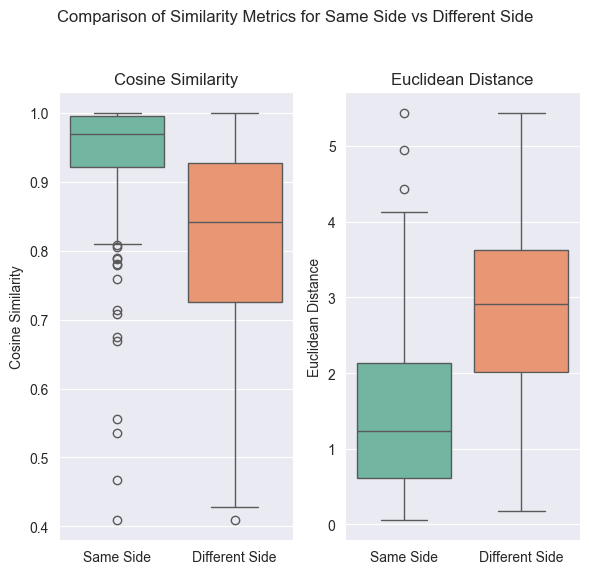

In [42]:
plot_combined_similarity_metrics(same_side_metrics, diff_side_metrics)

In [47]:

t_statistic, p_value = stats.ttest_ind(same_side_metrics[:20], diff_side_metrics[:20])
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Independent two-sample t-test:
t-statistic: [ 3.68059252  3.06908902 -4.08115429]
p-value: [0.00071928 0.00394947 0.00022179]


In [50]:
sampled_data = random.sample(same_side_metrics, 20)
same_sim_data = np.array([entry[0] for entry in sampled_data])
same_dist_data = np.array([entry[2] for entry in sampled_data])
sampled_data = random.sample(diff_side_metrics, 20)
diff_sim_data = np.array([entry[0] for entry in sampled_data])
diff_dist_data = np.array([entry[2] for entry in sampled_data])

t_statistic, p_value = stats.ttest_ind(same_sim_data,diff_sim_data)
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = stats.ttest_ind(same_dist_data, diff_dist_data)
print("\nIndependent two-sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)



Independent two-sample t-test:
t-statistic: 5.604283594321711
p-value: 1.986908133011935e-06

Independent two-sample t-test:
t-statistic: -6.91916138777923
p-value: 3.1642013839525126e-08


In [20]:
def calculate_rank_biserial_and_cohen_d(same_side_metrics, diff_side_metrics):
    """
    Calculate the rank-biserial correlation and Cohen's d for two sets of similarity scores.

    Parameters:
    - same_side_metrics: list of tuples (cos_sim, pearson_corr, dist) for same-side comparisons.
    - diff_side_metrics: list of tuples (cos_sim, pearson_corr, dist) for different-side comparisons.

    Returns:
    - rank_biserial_corr: float, rank-biserial correlation.
    - cohen_d: float, Cohen's d value.
    """
    # Extract cosine similarities from metrics
    same_side_cos_sim = [m[0] for m in same_side_metrics]
    diff_side_cos_sim = [m[0] for m in diff_side_metrics]

    # Rank all data points
    all_ranks = rankdata(same_side_cos_sim + diff_side_cos_sim)

    # Compute rank-biserial correlation for Mann-Whitney U
    n1 = len(same_side_cos_sim)
    n2 = len(diff_side_cos_sim)

    # Sum of ranks for each group
    R1 = sum(all_ranks[:n1])
    R2 = sum(all_ranks[n1:])

    # Compute rank-biserial correlation
    rank_biserial_corr = (2 * (R1 / n1 - R2 / n2)) / (n1 + n2)

    # Compute Cohen's d (for comparison)
    mean_diff = np.mean(same_side_cos_sim) - np.mean(diff_side_cos_sim)
    pooled_std = np.sqrt(((n1 - 1) * np.std(same_side_cos_sim, ddof=1) ** 2 +
                         (n2 - 1) * np.std(diff_side_cos_sim, ddof=1) ** 2) /
                         (n1 + n2 - 2))
    cohen_d = mean_diff / pooled_std

    return rank_biserial_corr, cohen_d


In [21]:
rank_biserial_corr, cohen_d = calculate_rank_biserial_and_cohen_d(same_side_metrics, diff_side_metrics)
print(f"Rank-biserial correlation: {rank_biserial_corr}")
print(f"Cohen's d: {cohen_d}")


Rank-biserial correlation: 0.6406757305194805
Cohen's d: 1.036272716419671


In [22]:
def compute_effect_sizes(same_side_metrics, diff_side_metrics):
    """
    Compute Mann-Whitney U test, rank-biserial correlation, and Cohen's d
    for both Cosine Similarity and Euclidean Distance.

    Parameters:
    - same_side_metrics: List of tuples (cosine_sim, pearson_corr, euclidean_dist) for same-side pairs.
    - diff_side_metrics: List of tuples (cosine_sim, pearson_corr, euclidean_dist) for different-side pairs.

    Returns:
    - dict: Results for cosine similarity and euclidean distance.
    """
    # Extract cosine similarity and distance values
    same_side_cosine = [m[0] for m in same_side_metrics]
    diff_side_cosine = [m[0] for m in diff_side_metrics]
    
    same_side_dist = [m[2] for m in same_side_metrics]
    diff_side_dist = [m[2] for m in diff_side_metrics]

    results = {}

    # Cosine Similarity Analysis
    u_stat, p_value = mannwhitneyu(same_side_cosine, diff_side_cosine, alternative='greater')
    rank_biserial_corr = (2 * u_stat) / (len(same_side_cosine) * len(diff_side_cosine)) - 1
    cohen_d = (np.mean(same_side_cosine) - np.mean(diff_side_cosine)) / np.sqrt(
        (np.std(same_side_cosine, ddof=1) ** 2 + np.std(diff_side_cosine, ddof=1) ** 2) / 2)

    results['cosine_similarity'] = {
        'u_statistic': u_stat,
        'p_value': p_value,
        'rank_biserial_corr': rank_biserial_corr,
        'cohen_d': cohen_d
    }

    # Euclidean Distance Analysis
    u_stat_dist, p_value_dist = mannwhitneyu(same_side_dist, diff_side_dist, alternative='less')
    rank_biserial_corr_dist = (2 * u_stat_dist) / (len(same_side_dist) * len(diff_side_dist)) - 1
    cohen_d_dist = (np.mean(same_side_dist) - np.mean(diff_side_dist)) / np.sqrt(
        (np.std(same_side_dist, ddof=1) ** 2 + np.std(diff_side_dist, ddof=1) ** 2) / 2)

    results['euclidean_distance'] = {
        'u_statistic': u_stat_dist,
        'p_value': p_value_dist,
        'rank_biserial_corr': rank_biserial_corr_dist,
        'cohen_d': cohen_d_dist
    }

    return results

In [23]:
print(compute_effect_sizes(same_side_metrics, diff_side_metrics))

{'cosine_similarity': {'u_statistic': 64682.0, 'p_value': 8.849052017584602e-39, 'rank_biserial_corr': 0.6406757305194806, 'cohen_d': 1.0879453013656666}, 'euclidean_distance': {'u_statistic': 13407.0, 'p_value': 5.07211039775246e-41, 'rank_biserial_corr': -0.6599279626623377, 'cohen_d': -1.3541408699402575}}
